In [29]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.tree import _tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import xgboost as xgb

In [30]:
# Load data
df = pd.read_csv("/content/sampled_data2.csv")
print(df.shape)
df.head()

(25200, 8)


,step,customer,age,gender,merchant,category,amount,fraud
0,2021-07-16,C1326593353,36to45,Male,M1823072687,Transportation,15.78,0
1,2021-08-22,C483912131,26to35,Female,M1198415165,Beauty&Wellness,608.32,1
2,2021-06-03,C1681589600,26to35,Female,M348934600,Transportation,43.76,0
3,2021-07-01,C1251749294,36to45,Female,M1823072687,Transportation,41.57,0
4,2021-03-06,C1705346216,36to45,Male,M348934600,Transportation,42.97,0


In [41]:
# check the rows and columns of this dataset
df.shape

(25200, 8)

In [42]:
# check datatypes to see if there are some wrongly categorized types
df.dtypes

step         object
customer     object
age          object
gender       object
merchant     object
category     object
amount      float64
fraud         int64
dtype: object

In [43]:
# check each columns number of unique values 
df.nunique()

step          180
customer     4061
age             8
gender          4
merchant       48
category       14
amount      12958
fraud           2
dtype: int64

In [44]:
# statistic values for this data 
df.describe()

,amount,fraud
count,25200.000000,25200.000000
mean,174.212506,0.285714
std,501.116240,0.451763
min,0.000000,0.000000
25%,17.720000,0.000000
50%,36.340000,0.000000
75%,109.180000,1.000000
max,8329.960000,1.000000


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   step      25200 non-null  object 
 1   customer  25200 non-null  object 
 2   age       25200 non-null  object 
 3   gender    25200 non-null  object 
 4   merchant  25200 non-null  object 
 5   category  25200 non-null  object 
 6   amount    25200 non-null  float64
 7   fraud     25200 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB


In [46]:
df.isnull().sum()

step        0
customer    0
age         0
gender      0
merchant    0
category    0
amount      0
fraud       0
dtype: int64

In [47]:
# check if there are some duplicates 
df.duplicated().sum()


0

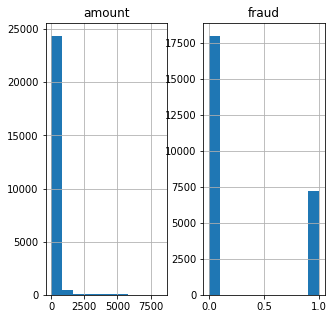

In [48]:
# visulize each variables 
df.hist(figsize=(5,5));

In [49]:
df['gender'].unique()

array(['Male', 'Female', 'Enterprise', 'Unknown'], dtype=object)

Text(0, 0.5, 'Gender')

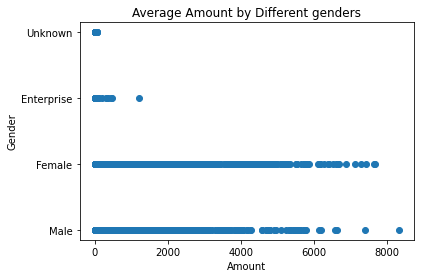

In [50]:
# plot the relation between amount and gender 
x = df['amount']
y = df['gender'] 

plt.scatter(x,y)
plt.title('Average Amount by Different genders',fontsize=12)
plt.xlabel('Amount',fontsize=10)
plt.ylabel('Gender',fontsize=10)

Text(0, 0.5, 'Gender')

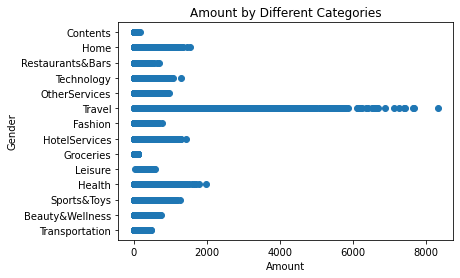

In [51]:
# plot the relation between amount and gender 
x = df['amount']
y = df['category'] 

plt.scatter(x,y)
plt.title('Amount by Different Categories',fontsize=12)
plt.xlabel('Amount',fontsize=10)
plt.ylabel('Gender',fontsize=10)

In [52]:
df['fraud'].value_counts()

0    18000
1     7200
Name: fraud, dtype: int64

In [53]:
print("Mean feature values per category",df.groupby('category')['amount','fraud'].mean())

Mean feature values per category                        amount     fraud
category                               
Beauty&Wellness    161.218987  0.605907
Contents            49.211111  0.000000
Fashion            128.272906  0.362500
Groceries           36.498291  0.000000
Health             344.405963  0.796992
Home               414.374669  0.870317
HotelServices      402.989454  0.935154
Leisure            300.286878  1.000000
OtherServices      295.230478  0.908367
Restaurants&Bars    90.103412  0.405405
Sports&Toys        338.154819  0.971569
Technology         331.232103  0.738318
Transportation      29.370946  0.017582
Travel            2649.873832  0.993127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


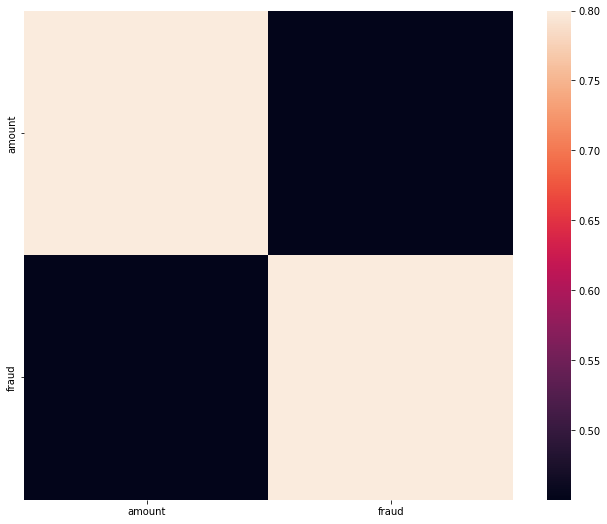

In [54]:
#corelation matrices
coret=df.corr()
fig=plt.figure(figsize=(12,9))
sns.heatmap(coret,vmax=.8,square=True)
plt.show()

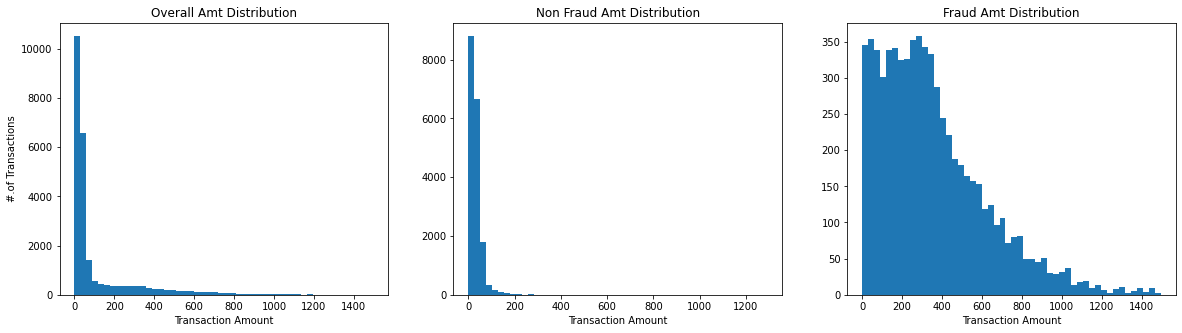

In [56]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist(df[df['amount']<=1500]['amount'], bins=50)
ax[1].hist(df[(df['fraud']==0) & (df['amount']<=1500)]['amount'], bins=50)
ax[2].hist(df[(df['fraud']==1) & (df['amount']<=1500)]['amount'], bins=50)

ax[0].set_title('Overall Amt Distribution')
ax[1].set_title('Non Fraud Amt Distribution')
ax[2].set_title('Fraud Amt Distribution')

ax[0].set_xlabel('Transaction Amount')
ax[0].set_ylabel('#.of Transactions')

ax[1].set_xlabel('Transaction Amount')
ax[2].set_xlabel('Transaction Amount')
plt.show()

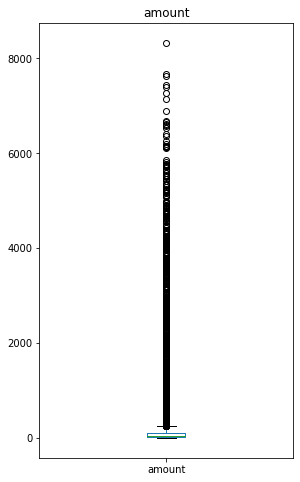

In [57]:
num_cols=['amount']
plt.figure(figsize=[10,8])
for ind, col in enumerate(num_cols):
    plt.subplot(1,2,ind+1)
    df[col].plot.box()
    plt.title(col)
plt.show()

In [58]:
df_gender = df[['gender','customer']].groupby(['gender']).count().reset_index()
df_gender.columns = ['Gender','gender_count']

df_gender['percent'] = (df_gender['gender_count']/df_gender['gender_count'].sum())*100

df_gender

,Gender,gender_count,percent
0,Enterprise,39,0.154762
1,Female,14596,57.920635
2,Male,10547,41.853175
3,Unknown,18,0.071429


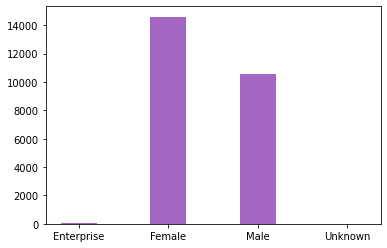

In [59]:
plt.bar(df_gender['Gender'], df_gender['gender_count'], color=(0.4, 0, 0.6, 0.6),  
        width = 0.4)

plt.show()

In [60]:
df_fraud_gender = df[['gender','fraud','customer']].groupby(['gender','fraud']).count().reset_index()
df_fraud_gender.columns = ['Gender','fraud','count']

df_fraud_gender = df_fraud_gender.merge(df_gender[['Gender','gender_count']],how='inner',\
                                  left_on='Gender',right_on='Gender')


df_fraud_gender['percent_grp'] = (df_fraud_gender['count']/df_fraud_gender['gender_count'])*100


df_fraud_gender

,Gender,fraud,count,gender_count,percent_grp
0,Enterprise,0,32,39,82.051282
1,Enterprise,1,7,39,17.948718
2,Female,0,9838,14596,67.402028
3,Female,1,4758,14596,32.597972
4,Male,0,8112,10547,76.912866
5,Male,1,2435,10547,23.087134
6,Unknown,0,18,18,100.000000


In [61]:
df_category = df[['category','customer']].groupby(['category']).count().reset_index()
df_category.columns = ['Category','category_count']

df_category['percent'] = (df_category['category_count']/df_category['category_count'].sum())*100

df_category.sort_values(by = ['percent'], ascending=False)

,Category,category_count,percent
12,Transportation,15925,63.194444
4,Health,2128,8.444444
10,Sports&Toys,2040,8.095238
0,Beauty&Wellness,1185,4.702381
3,Groceries,825,3.273810
6,HotelServices,586,2.325397
13,Travel,582,2.309524
7,Leisure,474,1.880952
5,Home,347,1.376984
2,Fashion,320,1.269841


In [62]:
df_category = df_category.sort_values(by = ['percent'], ascending=False).reset_index()
df_category

,index,Category,category_count,percent
0,12,Transportation,15925,63.194444
1,4,Health,2128,8.444444
2,10,Sports&Toys,2040,8.095238
3,0,Beauty&Wellness,1185,4.702381
4,3,Groceries,825,3.273810
5,6,HotelServices,586,2.325397
6,13,Travel,582,2.309524
7,7,Leisure,474,1.880952
8,5,Home,347,1.376984
9,2,Fashion,320,1.269841


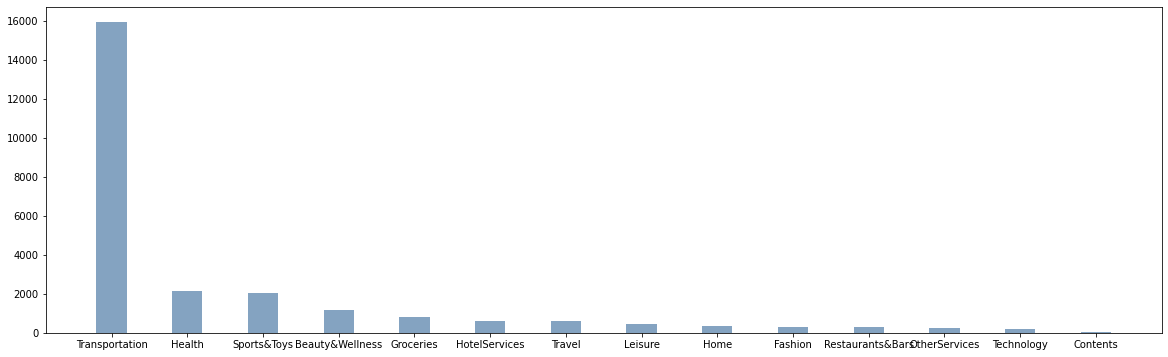

In [63]:
fig = plt.figure(figsize = (20, 6)) 


plt.bar(df_category['Category'], df_category['category_count'], color=(0.2, 0.4, 0.6, 0.6),  
        width = 0.4)

plt.show()

In [31]:
entity_column = 'customer'
target_column= 'fraud'
datetime_columns = 'step'

In [32]:
if entity_column == '':
    df['entity_column']= df.index.tolist()
    entity_column = 'entity_column' 
    
if datetime_columns == '':
    df['datetime_columns']= df.index.tolist()    
    datetime_columns = 'datetime_columns'

numerical_columns = df._get_numeric_data().columns.values.tolist()
print(numerical_columns)

['amount', 'fraud']


### Given model as sample

0.9956406858710563
[[13201   299]
 [  240  5160]]


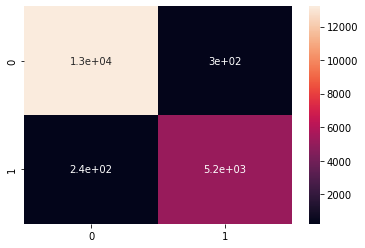

In [33]:
X = df.drop(columns=[entity_column,target_column,datetime_columns])
y = df[target_column]

# Label Encoding of Categorical Columns
categorical_names = {}
for feature in X.columns:
    X[feature] =  X[feature].fillna('') 
    le =  LabelEncoder()
    le.fit(X[feature])
    X[feature] = le.transform(X[feature])
    categorical_names[feature] = le.classes_
    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42,stratify=y)

rf = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

predictions = rf.predict_proba(X_test)
predictions_class = rf.predict(X_test)


if df[target_column].nunique()> 2:
    rules_score = roc_auc_score(y_test, predictions[:,1], multi_class = 'ovo')
else:
    rules_score = roc_auc_score(y_test, predictions[:,1])

print(rules_score)

from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions_class)
print(cf_matrix)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

### My prediction using different models.
- KNN
- Random Forest
- XGBosting

In [34]:
def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.96     13500
           1       0.93      0.85      0.89      5400

    accuracy                           0.94     18900
   macro avg       0.93      0.91      0.92     18900
weighted avg       0.94      0.94      0.94     18900

Confusion Matrix of K-Nearest Neigbours: 
 [[13147   353]
 [  823  4577]]


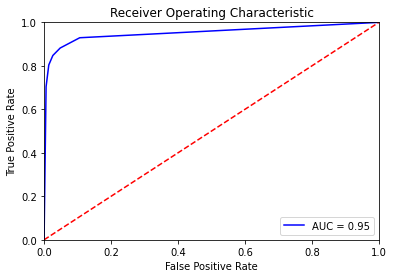

In [35]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     13500
           1       0.93      0.98      0.95      5400

    accuracy                           0.97     18900
   macro avg       0.96      0.97      0.97     18900
weighted avg       0.97      0.97      0.97     18900

Confusion Matrix of Random Forest Classifier: 
 [[13082   418]
 [  128  5272]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


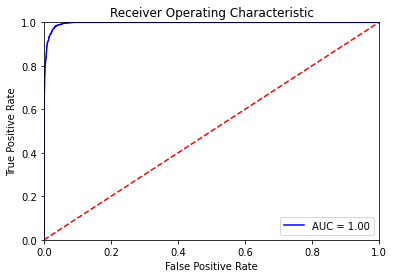

In [36]:
# %% Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     13500
           1       0.94      0.96      0.95      5400

    accuracy                           0.97     18900
   macro avg       0.96      0.97      0.97     18900
weighted avg       0.97      0.97      0.97     18900

Confusion Matrix of XGBoost: 
 [[13188   312]
 [  217  5183]]


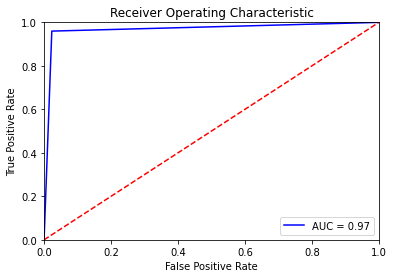

In [40]:
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)

XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])